In [4]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Get data

In [32]:
data = pd.read_csv('./data/simple_isomerization.csv')
data["feed_mass_flow"] = data["feed_mass_flow"] * 3600
data

,vessel_volume,feed_temperature,feed_mass_flow,tr2-butene_mass_fr,feed_mass_dens,prod_mass_dens,prod_temperature
0,0.01,27.5,500.04,0.9035,616.3583,565.5246,53.7641
1,0.01,27.5,500.04,0.9035,616.3583,565.5246,53.7641
2,0.11,16.0,1100.16,0.9794,629.9060,574.4067,46.0478
3,0.11,16.0,1100.16,0.9794,629.9060,574.4067,47.7235
4,0.11,18.0,1100.16,0.9793,627.5852,572.1964,47.7235
...,...,...,...,...,...,...,...
79996,4.51,50.0,13700.16,0.9932,588.1569,532.8819,74.9400
79997,4.51,50.0,13700.16,0.9932,588.1569,532.8819,74.9400
79998,4.51,50.0,13700.16,0.9932,588.1569,532.8819,74.9400
79999,4.51,50.0,13700.16,0.9932,588.1569,532.8819,74.9400


In [6]:
print(data['feed_mass_flow'].max())
print(data['feed_mass_flow'].min())

30499.920000000002
500.03999999999996


# Plots

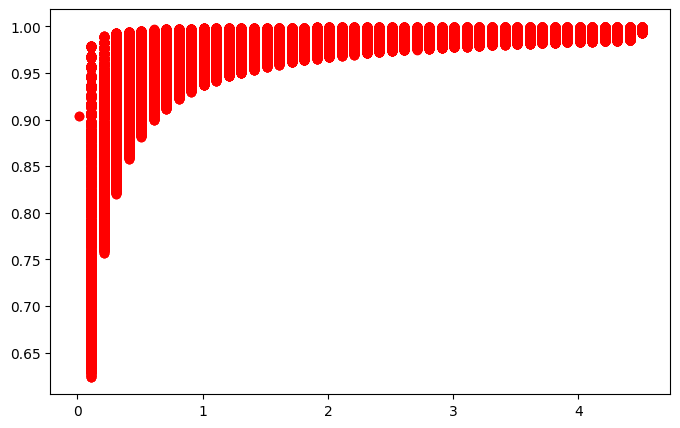

In [7]:
# Dependence of product concentration on reactor volume
plt.figure(figsize=(8, 5))

plt.scatter(data['vessel_volume'], data['tr2-butene_mass_fr'], c='r');

##### Dependence of product concentration on feed temperature
plt.figure(figsize=(8, 5))

plt.scatter(data['feed_temperature'], data['tr2-butene_mass_fr'], c='g');

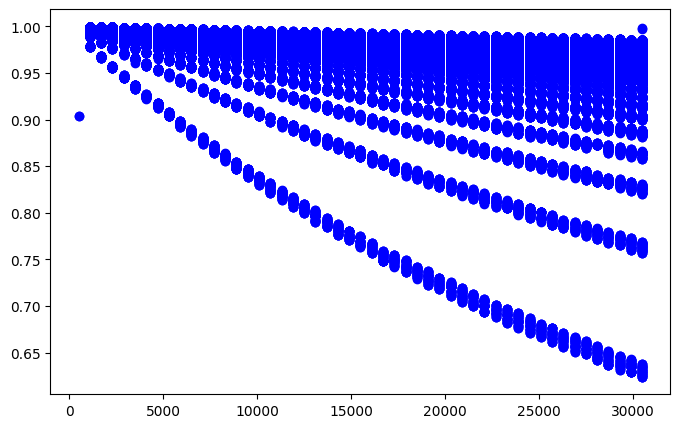

In [8]:
# Dependence of product concentration on feed mass flow
plt.figure(figsize=(8, 5))

plt.scatter(data['feed_mass_flow'], data['tr2-butene_mass_fr'], c='b');

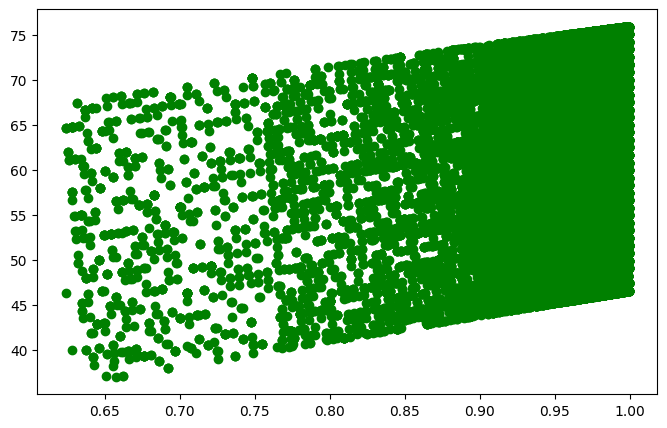

In [9]:
# Dependence of product temperature on product concentration
plt.figure(figsize=(8, 5))

plt.scatter(data['tr2-butene_mass_fr'], data['prod_temperature'], c='g');

# Create features and labels

In [11]:
list(data.columns)

['vessel_volume',
 'feed_temperature',
 'feed_mass_flow',
 'tr2-butene_mass_fr',
 'feed_mass_dens',
 'prod_mass_dens',
 'prod_temperature']

In [16]:
X = data[["vessel_volume", "feed_temperature", "feed_mass_flow"]]

y = data[["tr2-butene_mass_fr", "prod_temperature"]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), ["vessel_volume", "feed_temperature", "feed_mass_flow"])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_norm = ct.transform(X_train)
X_test_norm = ct.transform(X_test)
X_train_norm.shape, y_train.shape

((64000, 3), (64000, 2))

# Build a neural network

In [20]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
isomerization_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[3]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
isomerization_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
isomerization_model.fit(X_train_norm, y_train, epochs=10, batch_size=16)

Epoch 1/10
4000/4000 [==============================] - 8s 2ms/step - loss: 1.3922 - mae: 1.3922
Epoch 2/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4593 - mae: 0.4593
Epoch 3/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4525 - mae: 0.4525
Epoch 4/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4516 - mae: 0.4516
Epoch 5/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4514 - mae: 0.4514
Epoch 6/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4519 - mae: 0.4519
Epoch 7/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4533 - mae: 0.4533
Epoch 8/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4506 - mae: 0.4506
Epoch 9/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4507 - mae: 0.4507
Epoch 10/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4408 - mae: 0.4408


In [23]:
# Evaluate the model
isomerization_model.evaluate(X_test_norm, y_test)

501/501 [==============================] - 1s 2ms/step - loss: 0.3971 - mae: 0.3971


[0.397116482257843, 0.397116482257843]

In [28]:
# Testing model
vessel_volume = [0.5]
feed_temp = [40]
feed_mass_flow = [40000]

test_data = pd.DataFrame({
    'vessel_volume': vessel_volume,
    'feed_temperature': feed_temp,
    'feed_mass_flow': feed_mass_flow
})

test_data_norm = ct.transform(test_data)

print(test_data_norm)

isomerization_model.predict(test_data_norm)

[[0.10888889 0.68571429 1.3166706 ]]
1/1 [==============================] - 0s 17ms/step


array([[ 0.8393381, 62.90371  ]], dtype=float32)

# Save model

In [29]:
isomerization_model.save('./models/simple_isomerization/simple_isomerization_model.h5')

In [18]:
isomerization_model.save('./models/simple_isomerization/simple_isomerization_model_sv')

INFO:tensorflow:Assets written to: ./models/simple_isomerization/simple_isomerization_model_sv\assets


INFO:tensorflow:Assets written to: ./models/simple_isomerization/simple_isomerization_model_sv\assets


In [34]:
mini_data = data.sample(frac=0.05)
mini_data

,vessel_volume,feed_temperature,feed_mass_flow,tr2-butene_mass_fr,feed_mass_dens,prod_mass_dens,prod_temperature
44944,2.51,29.0,29900.16,0.9749,614.5528,559.8880,56.8577
10643,0.61,36.0,28100.16,0.9089,605.9974,555.1417,61.1425
10044,0.61,48.0,17899.92,0.9383,590.7720,538.5012,72.0282
77789,4.41,39.0,7099.92,0.9965,602.2610,546.7122,65.7882
77271,4.31,29.0,28699.92,0.9858,614.5528,559.2990,57.1301
...,...,...,...,...,...,...,...
43238,2.51,51.0,1100.16,0.9990,586.8402,531.2404,75.9059
64082,3.61,50.0,18500.04,0.9885,588.1569,533.1331,74.8395
58492,3.31,42.0,15500.16,0.9897,598.4796,543.3464,68.1502
70254,4.01,25.0,1699.92,0.9991,619.3468,563.2153,54.1101


In [35]:
mini_data.to_csv("mini_simple_iso.csv")